In [59]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import copy
from keras.models import Sequential
from keras.utils import set_random_seed
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow as tf
import os
from tensorflow.keras.regularizers import l2


In [78]:
# Load Metadata
metadata = pd.read_csv('./metadata.csv')

# Add file extension to image_id to create a new column for image files
metadata['image_file'] = metadata['image_id'] + '.jpg'

# Encode categorical data
encoder = OneHotEncoder(sparse_output=False)
type_cat = encoder.fit_transform(metadata['dx'].values.reshape(-1,1))

# Train-test split
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=42)

# Further split train_df into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Image paths and parameters
image_size = (200, 200)  # Use an image size of 200x200 as per the tips
num_classes = type_cat.shape[1]  # Number of classes based on one-hot encoding

# ImageDataGenerator for training, validation, and test data
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2
)
new_train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.2
)

test_image_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_image_gen.flow_from_dataframe(
    train_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

new_train_gen = new_train_image_gen.flow_from_dataframe(
    train_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

val_gen = train_image_gen.flow_from_dataframe(
    val_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

new_val_gen = new_train_image_gen.flow_from_dataframe(
    val_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

test_gen = test_image_gen.flow_from_dataframe(
    test_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 6058 validated image filenames belonging to 7 classes.
Found 6058 validated image filenames belonging to 7 classes.
Found 1515 validated image filenames belonging to 7 classes.
Found 1515 validated image filenames belonging to 7 classes.
Found 1894 validated image filenames belonging to 7 classes.


     lesion_id      image_id   dx    dx_type   age     sex     localization
0  HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk
1  HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity
2  HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk
3  HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk
4  HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest


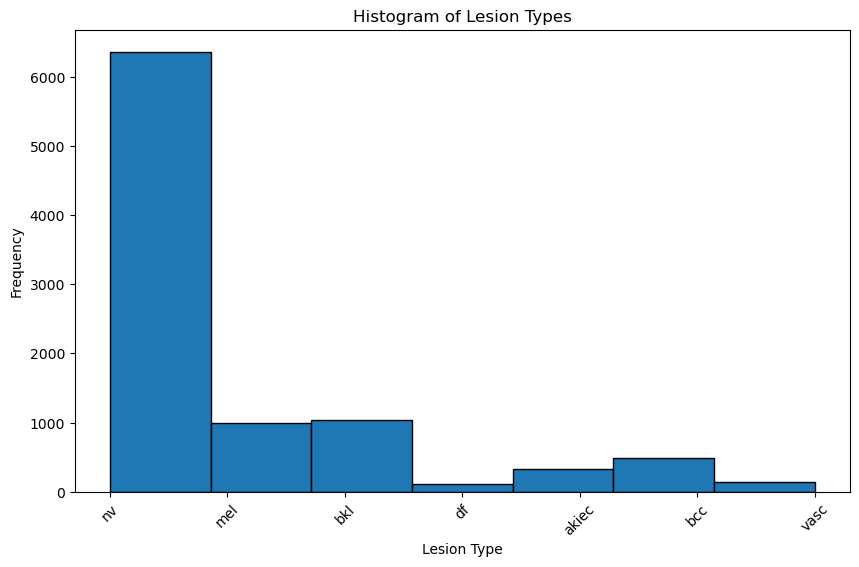

In [61]:
#1a
metadata = pd.read_csv('./metadata.csv')
print(metadata.head())

# Get the lesion types
lesion_types = metadata['dx']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(lesion_types, bins=len(lesion_types.unique()), edgecolor='black')
plt.title('Histogram of Lesion Types')

plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [62]:
# 1B: Create a classifier that always classifies the lesion as the most common occurring lesion
most_common_lesion = lesion_types.mode()[0]
print(f'Most common lesion type: {most_common_lesion}')

# Split data into training and test sets
train, test = train_test_split(metadata, test_size=0.2, random_state=42)

# Classifier that always predicts the most common lesion
y_pred = [most_common_lesion] * len(test)
y_true = test['dx']


Most common lesion type: nv


In [63]:
# 1C: Calculate the test accuracy of this classifier
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6579


In [64]:
# 1D: Calculate the test sensitivity and specificity of this classifier for each class
conf_matrix = confusion_matrix(y_true, y_pred, labels=lesion_types.unique())
report = classification_report(y_true, y_pred, target_names=lesion_types.unique(), output_dict=True)

sensitivity_specificity = {}
for lesion in lesion_types.unique():
    sensitivity = report[lesion]['recall']
    specificity = (conf_matrix.sum() - conf_matrix[:, lesion_types.unique().tolist().index(lesion)].sum() - conf_matrix[lesion_types.unique().tolist().index(lesion)].sum() + conf_matrix[lesion_types.unique().tolist().index(lesion), lesion_types.unique().tolist().index(lesion)]) / (conf_matrix.sum() - conf_matrix[:, lesion_types.unique().tolist().index(lesion)].sum())
    sensitivity_specificity[lesion] = {
        'sensitivity': sensitivity,
        'specificity': specificity
    }

# Print the sensitivity and specificity for each class
for lesion, metrics in sensitivity_specificity.items():
    print(f'{lesion}: Sensitivity = {metrics["sensitivity"]:.4f}, Specificity = {metrics["specificity"]:.4f}')

nv: Sensitivity = 0.0000, Specificity = nan
mel: Sensitivity = 0.0000, Specificity = 0.8897
bkl: Sensitivity = 0.0000, Specificity = 0.8918
df: Sensitivity = 0.0000, Specificity = 0.9873
akiec: Sensitivity = 0.0000, Specificity = 0.9630
bcc: Sensitivity = 1.0000, Specificity = 0.9461
vasc: Sensitivity = 0.0000, Specificity = 0.9799


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/3y/88h70jc14nsgv71207t3cb000000gn/T/ipy

In [65]:
#2a
# gscv initialize
gscv = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid={'max_depth': range(1,40,5), 'n_estimators': range(1,50,5)}, verbose = 4, return_train_score=True)

# train test split
x_train, x_test, y_train, y_test = train_test_split(features_cat, type_cat, test_size=0.2, random_state=0)


# fit model
gscv.fit(x_train, y_train)
train_accuracy = gscv.score(x_train,y_train)
test_accuracy = gscv.score(x_test,y_test)
print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)
print(gscv.best_params_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=1, n_estimators=1;, score=(train=0.646, test=0.663) total time=   0.0s
[CV 2/5] END max_depth=1, n_estimators=1;, score=(train=0.651, test=0.644) total time=   0.0s
[CV 3/5] END max_depth=1, n_estimators=1;, score=(train=0.644, test=0.669) total time=   0.0s
[CV 4/5] END max_depth=1, n_estimators=1;, score=(train=0.652, test=0.640) total time=   0.0s
[CV 5/5] END max_depth=1, n_estimators=1;, score=(train=0.654, test=0.630) total time=   0.0s
[CV 1/5] END max_depth=1, n_estimators=6;, score=(train=0.668, test=0.680) total time=   0.0s
[CV 2/5] END max_depth=1, n_estimators=6;, score=(train=0.672, test=0.663) total time=   0.0s
[CV 3/5] END max_depth=1, n_estimators=6;, score=(train=0.665, test=0.688) total time=   0.0s
[CV 4/5] END max_depth=1, n_estimators=6;, score=(train=0.672, test=0.661) total time=   0.0s
[CV 5/5] END max_depth=1, n_estimators=6;, score=(train=0.673, test=0.658) total time=   0.0

In [66]:
#2d
# create variables for actual output vs predicted output
g_actual = type_cat
g_pred = gscv.predict(features_cat)

# mild to severe: 2-4

# conditions for true positive, true negatives, false negatives, and false positives
tp0 = (g_actual==0) & (g_pred ==0)
tp1 = (g_actual==1) & (g_pred ==1)
tp2 = (g_actual==2) & (g_pred ==2)
tp3 = (g_actual==3) & (g_pred ==3)
tp4 = (g_actual==4) & (g_pred ==4)
tp5 = (g_actual==5) & (g_pred ==5)
tp6 = (g_actual==6) & (g_pred ==6)


tn0 = (g_actual!=0) & (g_pred !=0)
tn1 = (g_actual!=1) & (g_pred !=1)
tn2 = (g_actual!=2) & (g_pred !=2)
tn3 = (g_actual!=3) & (g_pred !=3)
tn4 = (g_actual!=4) & (g_pred !=4)
tn5 = (g_actual!=5) & (g_pred !=5)
tn6 = (g_actual!=6) & (g_pred !=6)


fn0 = (g_actual==0) & (g_pred !=0)
fn1 = (g_actual==1) & (g_pred !=1)
fn2 = (g_actual==2) & (g_pred !=2)
fn3 = (g_actual==3) & (g_pred !=3)
fn4 = (g_actual==4) & (g_pred !=4)
fn5 = (g_actual==5) & (g_pred !=5)
fn6 = (g_actual==6) & (g_pred !=6)

fp0 = (g_actual!=0) & (g_pred ==0)
fp1 = (g_actual!=1) & (g_pred ==1)
fp2 = (g_actual!=2) & (g_pred ==2)
fp3 = (g_actual!=3) & (g_pred ==3)
fp4 = (g_actual!=4) & (g_pred ==4)
fp5 = (g_actual!=5) & (g_pred ==5)
fp6 = (g_actual!=6) & (g_pred ==6)


# calculate tp, fn, fp, tn
tp = tp0.sum()+tp1.sum()+tp2.sum()+tp3.sum()+tp4.sum()+tp5.sum()+tp6.sum()
fn = fn0.sum()+fn1.sum()+fn2.sum()+fn3.sum()+fn4.sum()+fn5.sum()+fn6.sum()
fp = fp0.sum()+fp1.sum()+fp2.sum() + fp3.sum() +fp4.sum()+ fp5.sum()+ fp6.sum()
tn =  tn0.sum()+tn1.sum()+tn2.sum() + tn3.sum() + tn4.sum()+tn5.sum()+tn6.sum()

# confusion matrix of results
cm = np.array([[tp, fn],[fp, tn]])
print(cm)


# calculate sensitivity and specificity
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)


# print results
print('Sensitivity total: %.3f' % sensitivity)
print('Specificity total: %.3f' % specificity)


[[ 60057   6212]
 [  6212 391402]]
Sensitivity total: 0.906
Specificity total: 0.984


In [67]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 48672)             0         
                                                                 
 dense_22 (Dense)            (None, 7)                 340711    
                                                                 
Total params: 341,607
Trainable params: 341,607
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Train the model
history = model.fit(train_gen, epochs=5, validation_data=val_gen, batch_size=32, verbose=1)

Epoch 1/5


2024-05-21 19:22:08.151886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.6613

2024-05-21 19:23:20.458278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 87s 457ms/step - loss: 1.1219 - accuracy: 0.6613 - val_loss: 0.9523 - val_accuracy: 0.6785
Epoch 2/5
190/190 [==============================] - 81s 424ms/step - loss: 0.9249 - accuracy: 0.6751 - val_loss: 0.9056 - val_accuracy: 0.6799
Epoch 3/5
190/190 [==============================] - 82s 430ms/step - loss: 0.8862 - accuracy: 0.6812 - val_loss: 0.8659 - val_accuracy: 0.6904
Epoch 4/5
190/190 [==============================] - 82s 430ms/step - loss: 0.8504 - accuracy: 0.6883 - val_loss: 0.8300 - val_accuracy: 0.7096
Epoch 5/5
190/190 [==============================] - 79s 417ms/step - loss: 0.8192 - accuracy: 0.7025 - val_loss: 0.8133 - val_accuracy: 0.7096


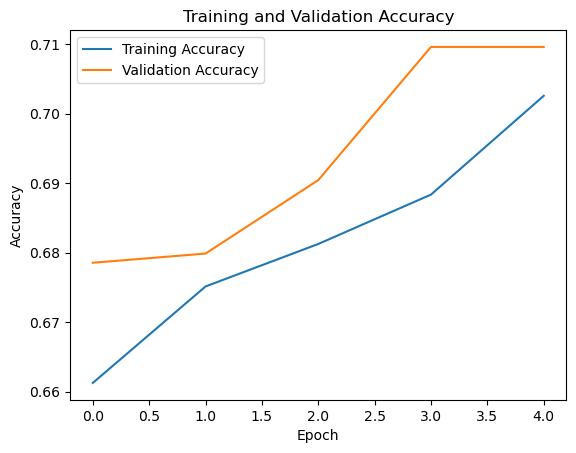

In [69]:
#3a: Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
#3b: Evaluate the model on test data
train_loss, train_accuracy = model.evaluate(train_gen)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



2024-05-21 19:28:58.977531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/60 [..............................] - ETA: 11s - loss: 0.7147 - accuracy: 0.7188

2024-05-21 19:29:53.805998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 10s 164ms/step - loss: 0.8658 - accuracy: 0.6779
Training Accuracy: 0.7060
Test Accuracy: 0.6779


In [55]:
#3c: Predict the classes for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_gen.classes

# Calculate sensitivity and specificity for each class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = encoder.categories_[0]  # Assuming 'dx' is the only encoded category
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

2024-05-21 19:18:31.150669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 11s 188ms/step
Confusion Matrix:
[[   0    7   31    0    0   32    0]
 [   0   31   37    0    1   33    0]
 [   0    8  106    0    7   84    0]
 [   0    3   14    0    0    7    0]
 [   0    4   46    0   10  149    0]
 [   0    6   90    0   21 1129    0]
 [   0   12    0    0    1   22    3]]

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        70
         bcc       0.44      0.30      0.36       102
         bkl       0.33      0.52      0.40       205
          df       0.00      0.00      0.00        24
         mel       0.25      0.05      0.08       209
          nv       0.78      0.91      0.84      1246
        vasc       1.00      0.08      0.15        38

    accuracy                           0.68      1894
   macro avg       0.40      0.26      0.26      1894
weighted avg       0.62      0.68      0.62      1894



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_23 (Dense)            (None, 128)              

In [72]:
# Train the model
history = model.fit(train_gen, epochs=5, validation_data=val_gen)

Epoch 1/5


2024-05-21 19:30:04.265851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - ETA: 0s - loss: 1.1311 - accuracy: 0.6633

2024-05-21 19:31:01.342284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 70s 368ms/step - loss: 1.1311 - accuracy: 0.6633 - val_loss: 0.9430 - val_accuracy: 0.6792
Epoch 2/5
190/190 [==============================] - 73s 382ms/step - loss: 0.9758 - accuracy: 0.6727 - val_loss: 0.8856 - val_accuracy: 0.6812
Epoch 3/5
190/190 [==============================] - 70s 369ms/step - loss: 0.9275 - accuracy: 0.6740 - val_loss: 0.8477 - val_accuracy: 0.6924
Epoch 4/5
190/190 [==============================] - 69s 363ms/step - loss: 0.8812 - accuracy: 0.6771 - val_loss: 0.8060 - val_accuracy: 0.6904
Epoch 5/5
190/190 [==============================] - 69s 364ms/step - loss: 0.8544 - accuracy: 0.6844 - val_loss: 0.7961 - val_accuracy: 0.6957


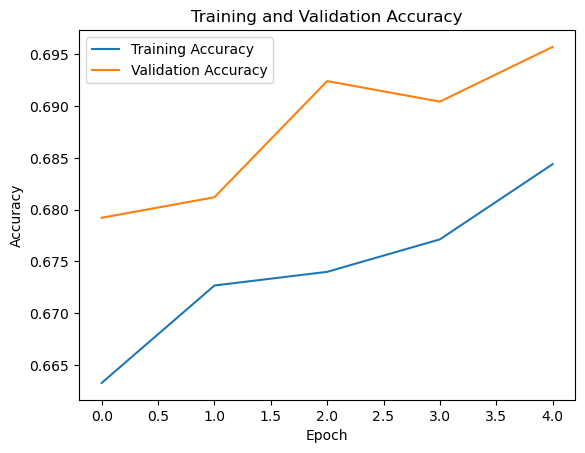

2024-05-21 19:35:56.062307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/60 [..............................] - ETA: 11s - loss: 0.8509 - accuracy: 0.6875

2024-05-21 19:36:46.856568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 10s 161ms/step - loss: 0.8500 - accuracy: 0.6790
Training Accuracy: 0.6936
Test Accuracy: 0.6790


2024-05-21 19:36:56.686683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 10s 161ms/step
Confusion Matrix:
[[   0    8   21    0    0   41    0]
 [   0   18   15    0    0   69    0]
 [   0    5   34    0    0  166    0]
 [   0    2    6    0    0   16    0]
 [   0    0   17    0    0  192    0]
 [   0    5    7    0    0 1234    0]
 [   0    3    0    0    0   35    0]]

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        70
         bcc       0.44      0.18      0.25       102
         bkl       0.34      0.17      0.22       205
          df       0.00      0.00      0.00        24
         mel       0.00      0.00      0.00       209
          nv       0.70      0.99      0.82      1246
        vasc       0.00      0.00      0.00        38

    accuracy                           0.68      1894
   macro avg       0.21      0.19      0.19      1894
weighted avg       0.52      0.68      0.58      1894



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
#4a
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#4b
# Training and test accuracy
train_loss, train_accuracy = model.evaluate(train_gen)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

#4c
# Predict classes for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_gen.classes

# Calculate sensitivity and specificity for each class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = encoder.categories_[0]  # Assuming 'dx' is the last encoded category
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

In [79]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, type_cat, test_size=0.2, random_state=0)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(5, 5)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [80]:
# Train the model
history = model.fit(new_train_gen, epochs=5, validation_data=new_val_gen, batch_size=32, verbose=1)


Epoch 1/5


2024-05-21 19:39:08.566114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - ETA: 0s - loss: 1.1702 - accuracy: 0.6593

2024-05-21 19:40:09.354804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 75s 393ms/step - loss: 1.1702 - accuracy: 0.6593 - val_loss: 0.9679 - val_accuracy: 0.6792
Epoch 2/5
190/190 [==============================] - 73s 381ms/step - loss: 1.0064 - accuracy: 0.6768 - val_loss: 0.9227 - val_accuracy: 0.6818
Epoch 3/5
190/190 [==============================] - 72s 378ms/step - loss: 0.9592 - accuracy: 0.6765 - val_loss: 0.9411 - val_accuracy: 0.6838
Epoch 4/5
190/190 [==============================] - 72s 379ms/step - loss: 0.9244 - accuracy: 0.6841 - val_loss: 0.8556 - val_accuracy: 0.6931
Epoch 5/5
190/190 [==============================] - 73s 381ms/step - loss: 0.9043 - accuracy: 0.6786 - val_loss: 0.8470 - val_accuracy: 0.6805


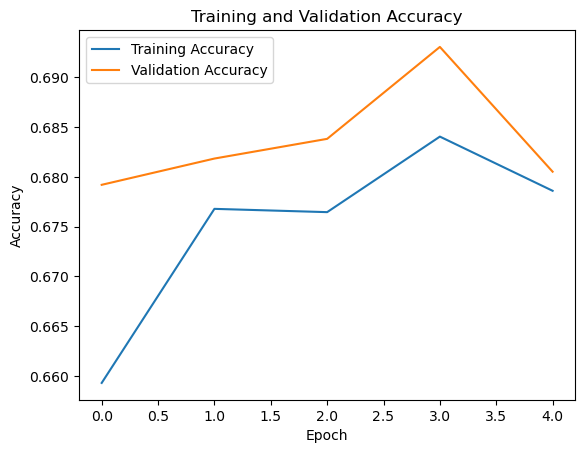

2024-05-21 19:45:12.992186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/60 [..............................] - ETA: 11s - loss: 0.8467 - accuracy: 0.6875

2024-05-21 19:46:07.791991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 10s 158ms/step - loss: 0.8871 - accuracy: 0.6779
Training Accuracy: 0.6865
Test Accuracy: 0.6779


2024-05-21 19:46:17.485915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 10s 161ms/step
Confusion Matrix:
[[   0    0   30    0    0   40    0]
 [   0    0   54    0    0   48    0]
 [   0    0   64    0    0  141    0]
 [   0    0   12    0    0   12    0]
 [   0    0   14    0    0  195    0]
 [   0    0   26    0    0 1220    0]
 [   0    0   15    0    0   23    0]]

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        70
         bcc       0.00      0.00      0.00       102
         bkl       0.30      0.31      0.30       205
          df       0.00      0.00      0.00        24
         mel       0.00      0.00      0.00       209
          nv       0.73      0.98      0.83      1246
        vasc       0.00      0.00      0.00        38

    accuracy                           0.68      1894
   macro avg       0.15      0.18      0.16      1894
weighted avg       0.51      0.68      0.58      1894



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
#5a
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#5b
# Training and test accuracy
train_loss, train_accuracy = model.evaluate(new_train_gen)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

#5c
# Predict classes for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_gen.classes

# Calculate sensitivity and specificity for each class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = encoder.categories_[0]  # Assuming 'dx' is the last encoded category
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

In [82]:
# Train the model
history = model.fit(new_train_gen, epochs=10, validation_data=new_val_gen, batch_size=32, verbose=1)


Epoch 1/10


2024-05-21 19:46:27.680817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 0.6859

2024-05-21 19:47:26.724853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 73s 382ms/step - loss: 0.8941 - accuracy: 0.6859 - val_loss: 0.8411 - val_accuracy: 0.6911
Epoch 2/10
190/190 [==============================] - 73s 382ms/step - loss: 0.8735 - accuracy: 0.6801 - val_loss: 0.8093 - val_accuracy: 0.6911
Epoch 3/10
190/190 [==============================] - 73s 385ms/step - loss: 0.8570 - accuracy: 0.6857 - val_loss: 0.8157 - val_accuracy: 0.6865
Epoch 4/10
190/190 [==============================] - 74s 390ms/step - loss: 0.8452 - accuracy: 0.6852 - val_loss: 0.7909 - val_accuracy: 0.7089
Epoch 5/10
190/190 [==============================] - 73s 384ms/step - loss: 0.8401 - accuracy: 0.6969 - val_loss: 0.7808 - val_accuracy: 0.7109
Epoch 6/10
190/190 [==============================] - 73s 383ms/step - loss: 0.8310 - accuracy: 0.6930 - val_loss: 0.7810 - val_accuracy: 0.7188
Epoch 7/10
190/190 [==============================] - 73s 383ms/step - loss: 0.8126 - accuracy: 0.7025 - val_loss: 0.7545 - val_accuracy: 0.7

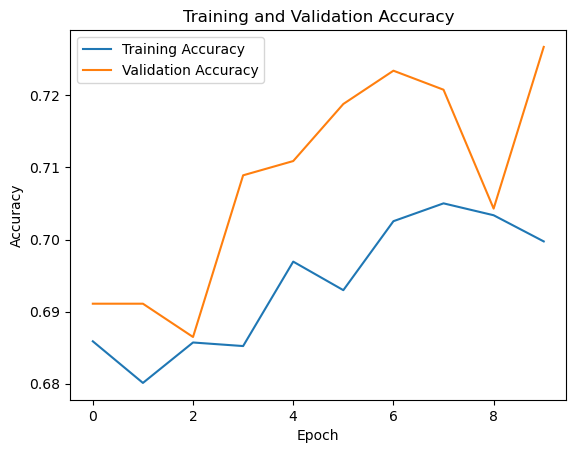

2024-05-21 19:58:37.699341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 55s 291ms/step - loss: 0.7347 - accuracy: 0.7299


2024-05-21 19:59:33.238369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 47s 795ms/step - loss: 0.7733 - accuracy: 0.7191
Training Accuracy: 0.7299
Test Accuracy: 0.7191


2024-05-21 20:00:20.541294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 104s 2s/step
Confusion Matrix:
[[   0   12   32    0    6   20    0]
 [   0   42   31    0    1   28    0]
 [   0   10   84    0   15   96    0]
 [   0    3   12    0    1    8    0]
 [   0    2   37    0   56  113    1]
 [   1    9   37    0   37 1161    1]
 [   0    4    2    0    0   13   19]]

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        70
         bcc       0.51      0.41      0.46       102
         bkl       0.36      0.41      0.38       205
          df       0.00      0.00      0.00        24
         mel       0.48      0.27      0.34       209
          nv       0.81      0.93      0.86      1246
        vasc       0.90      0.50      0.64        38

    accuracy                           0.72      1894
   macro avg       0.44      0.36      0.38      1894
weighted avg       0.67      0.72      0.69      1894



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
#6a
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#6b
# Training and test accuracy
train_loss, train_accuracy = model.evaluate(new_train_gen)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

#6c
# Predict classes for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_gen.classes

# Calculate sensitivity and specificity for each class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = encoder.categories_[0]  # Assuming 'dx' is the last encoded category
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

In [39]:

# Add file extension to image_id to create a new column for image files
metadata['image_file'] = metadata['image_id'] + '.jpg'

# Encode categorical data
encoder = OneHotEncoder(sparse_output=False)
type_cat = encoder.fit_transform(metadata['dx'].values.reshape(-1,1))

# Train-test split
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=0)

# Image paths and parameters
image_size = (32, 32)
num_classes = type_cat.shape[1]  # Number of classes based on one-hot encoding

# ImageDataGenerator for training and test data
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  # Use 20% of training data for validation
)

test_image_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_image_gen.flow_from_dataframe(
    train_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

val_gen = train_image_gen.flow_from_dataframe(
    train_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

test_gen = test_image_gen.flow_from_dataframe(
    test_df,
    directory='./Images/',
    x_col='image_file',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(image_size[0], image_size[1], 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(5, 5)),
    
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(5, 5)),
    
    Flatten(),
    Dense(128, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 6059 validated image filenames belonging to 7 classes.
Found 1514 validated image filenames belonging to 7 classes.
Found 1894 validated image filenames belonging to 7 classes.


In [40]:
# Train the model for 10 epochs
history = model.fit(train_gen, epochs=10, validation_data=val_gen)


Epoch 1/10


2024-05-21 17:35:53.361100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - ETA: 0s - loss: 3.3531 - accuracy: 0.6097

2024-05-21 17:36:24.110120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


190/190 [==============================] - 38s 199ms/step - loss: 3.3531 - accuracy: 0.6097 - val_loss: 2.9958 - val_accuracy: 0.6856
Epoch 2/10
190/190 [==============================] - 38s 199ms/step - loss: 2.3476 - accuracy: 0.6630 - val_loss: 2.4656 - val_accuracy: 0.6856
Epoch 3/10
190/190 [==============================] - 38s 199ms/step - loss: 1.7810 - accuracy: 0.6739 - val_loss: 1.5620 - val_accuracy: 0.6962
Epoch 4/10
190/190 [==============================] - 38s 202ms/step - loss: 1.4557 - accuracy: 0.6721 - val_loss: 1.3033 - val_accuracy: 0.6915
Epoch 5/10
190/190 [==============================] - 38s 199ms/step - loss: 1.2390 - accuracy: 0.6815 - val_loss: 1.1817 - val_accuracy: 0.7015
Epoch 6/10
190/190 [==============================] - 38s 199ms/step - loss: 1.1308 - accuracy: 0.6834 - val_loss: 1.0369 - val_accuracy: 0.7034
Epoch 7/10
190/190 [==============================] - 38s 201ms/step - loss: 1.0551 - accuracy: 0.6856 - val_loss: 1.0002 - val_accuracy: 0.7

In [84]:
suggested tweaks:


SyntaxError: invalid syntax (633725946.py, line 1)

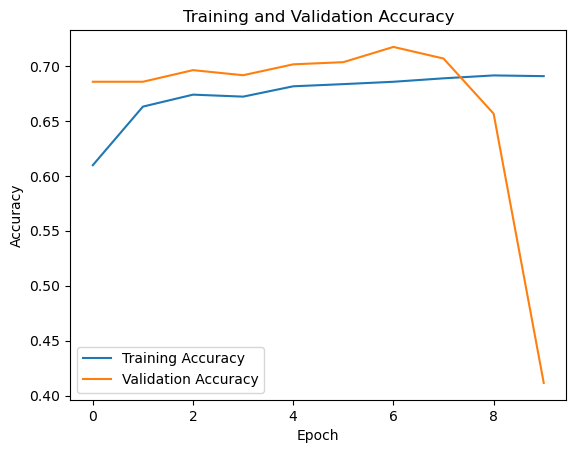

2024-05-21 17:42:13.742177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/60 [..............................] - ETA: 9s - loss: 1.3104 - accuracy: 0.4375

2024-05-21 17:42:44.208143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 9s 151ms/step - loss: 1.4253 - accuracy: 0.4018
Training Accuracy: 0.4138
Test Accuracy: 0.4018


2024-05-21 17:42:53.414100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 9s 149ms/step
Confusion Matrix:
[[  2   1  46   0  11   0   0]
 [  4   6  76   0  13   0   0]
 [  1   1 128   0  86   1   0]
 [  0   0  17   0   3   0   0]
 [  0   0  40   0 175   0   0]
 [  1   1 148   0 663 446   0]
 [  3   6   3   0   8   0   4]]

Classification Report:
              precision    recall  f1-score   support

       akiec       0.18      0.03      0.06        60
         bcc       0.40      0.06      0.11        99
         bkl       0.28      0.59      0.38       217
          df       0.00      0.00      0.00        20
         mel       0.18      0.81      0.30       215
          nv       1.00      0.35      0.52      1259
        vasc       1.00      0.17      0.29        24

    accuracy                           0.40      1894
   macro avg       0.43      0.29      0.24      1894
weighted avg       0.76      0.40      0.44      1894



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
#7a
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#7b
# Training and test accuracy
train_loss, train_accuracy = model.evaluate(train_gen)
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



#7c
# Predict classes for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_gen.classes

# Calculate sensitivity and specificity for each class
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = encoder.categories_[0]  # Assuming 'dx' is the only encoded category
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)